In [ ]:
# Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/sales_train.csv', header = 0)

In [ ]:
#display dataframe
df_train.head(5)

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0.0
1,1,2013-01-01,1,BABY CARE,0.0,0.0
2,2,2013-01-01,1,BEAUTY,0.0,0.0
3,3,2013-01-01,1,BEVERAGES,0.0,0.0
4,4,2013-01-01,1,BOOKS,0.0,0.0


In [ ]:
#format date column
df_train['date'] = pd.to_datetime(df_train['date'], format = "%Y-%m-%d")
#filter the data by specific product and date range
df_sales = df_train.loc[(df_train['family'] == 'MAGAZINES') & (df_train['date'] >= '2014-01-01')].groupby(['date']).sum().copy()
#slice the target sales column
df_sales = df_sales.loc[:, 'sales':'sales']

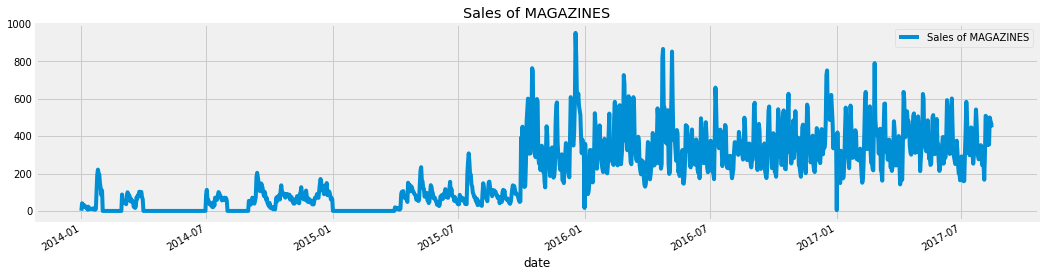

In [ ]:
#plot the sales of the magazines product since 2014-01-01
df_sales["sales"].plot(figsize=(16,4),legend=True)
plt.legend(['Sales of MAGAZINES'])
plt.title('Sales of MAGAZINES')
plt.show()

In [ ]:
#split the in_data based on previous_step values
def generate_features(in_data, previous_step):
	data_X, data_Y = [], []
	for i in range(len(in_data)-previous_step-1):
		first_half_data = in_data[i:(i+previous_step), 0]
		data_X.append(first_half_data)
		data_Y.append(in_data[i + previous_step, 0])
	return np.array(data_X), np.array(data_Y)

In [ ]:
df_sales = df_sales.astype('float32')
# normalize with minmax scaler to range of 0, 1
MMscaler = MinMaxScaler(feature_range=(0, 1))
df_sales_scaled = MMscaler.fit_transform(df_sales)

# split into 80% for training and 20% for testing sets
train_size = int(len(df_sales_scaled) * 0.8)
test_size = len(df_sales_scaled) - train_size
train_scaled, test_scaled = df_sales_scaled[0:train_size,:], df_sales_scaled[train_size:len(df_sales_scaled),:]

#use previous 60 step for as input features
previous_step = 60

#generate input features
trainX, trainY = generate_features(train_scaled, previous_step)

#reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))


In [ ]:
#define and fit the LSTM networ model
LSTMmodel = Sequential()
#define 60 units with activation relu
LSTMmodel.add(LSTM(60, activation='relu', return_sequences=True, input_shape=(1, previous_step)))
#define 30 units
LSTMmodel.add(LSTM(30))
LSTMmodel.add(Dense(1))
#use mean squared error as loss function, adam as optimizer
LSTMmodel.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
#fit the model with training data
history = LSTMmodel.fit(trainX, trainY, epochs=50, batch_size=1, verbose=2)

Epoch 1/50
995/995 - 5s - loss: 0.0093 - accuracy: 0.2131 - 5s/epoch - 5ms/step
Epoch 2/50
995/995 - 2s - loss: 0.0062 - accuracy: 0.2131 - 2s/epoch - 3ms/step
Epoch 3/50
995/995 - 3s - loss: 0.0052 - accuracy: 0.2131 - 3s/epoch - 3ms/step
Epoch 4/50
995/995 - 2s - loss: 0.0048 - accuracy: 0.2131 - 2s/epoch - 2ms/step
Epoch 5/50
995/995 - 3s - loss: 0.0042 - accuracy: 0.2131 - 3s/epoch - 3ms/step
Epoch 6/50
995/995 - 3s - loss: 0.0040 - accuracy: 0.2131 - 3s/epoch - 3ms/step
Epoch 7/50
995/995 - 2s - loss: 0.0037 - accuracy: 0.2131 - 2s/epoch - 2ms/step
Epoch 8/50
995/995 - 2s - loss: 0.0037 - accuracy: 0.2131 - 2s/epoch - 2ms/step
Epoch 9/50
995/995 - 3s - loss: 0.0036 - accuracy: 0.2131 - 3s/epoch - 3ms/step
Epoch 10/50
995/995 - 3s - loss: 0.0035 - accuracy: 0.2131 - 3s/epoch - 3ms/step
Epoch 11/50
995/995 - 3s - loss: 0.0033 - accuracy: 0.2131 - 3s/epoch - 3ms/step
Epoch 12/50
995/995 - 2s - loss: 0.0035 - accuracy: 0.2131 - 2s/epoch - 2ms/step
Epoch 13/50
995/995 - 2s - loss: 0.00

In [ ]:
LSTMmodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 60)             29040     
                                                                 
 lstm_1 (LSTM)               (None, 30)                10920     
                                                                 
 dense (Dense)               (None, 1)                 31        
                                                                 
Total params: 39,991
Trainable params: 39,991
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#predict training label Y from LSTM model
trainY_predict = LSTMmodel.predict(trainX)
#inverse scale for the trainY_predict
trainY_predict = MMscaler.inverse_transform(trainY_predict)
#inverse scale for the trainY
trainY = MMscaler.inverse_transform([trainY])
#reshape the trainY for RMSE calculation
trainY = trainY.reshape(-1,1)

In [ ]:
#calculate RMSE for training
train_RMSE = math.sqrt(mean_squared_error(trainY, trainY_predict[:,0]))
print('Train Score: %.2f RMSE' % (train_RMSE))

Train Score: 40.91 RMSE


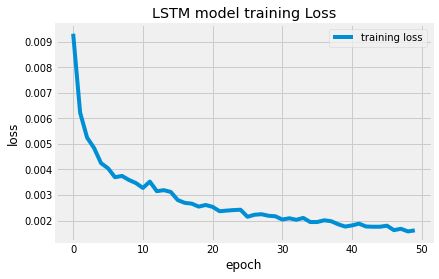

In [ ]:
plt.plot(history.history['loss'], label='training loss')
plt.title("LSTM model training Loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

In [ ]:
#generate the features for testing data
testX, testY = generate_features(test_scaled, previous_step)
#reshape input to be [samples, time steps, features]
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
#predict the testing one by one
#use the predicted y as input feature to predict y + 1 days
testY_predict_rolling=[]
single_testX = testX[0, 0]

#days to predict
days_to_predict = 45
for idx in range(days_to_predict):
  single_testX = np.reshape(single_testX, (1, 1, 60))
  #use one record to predict
  single_testY_predict = LSTMmodel.predict(single_testX)
  testY_predict_rolling.append(single_testY_predict[0][0])
  #roll the input feature at -1 step
  single_testX = np.roll(single_testX, -1)
  #use the predicted y as input feature to predict y + 1 days
  single_testX[0,0,59] = single_testY_predict[0][0]


In [ ]:
#reshape the testY_predict_rolling for RMSE calculation
testY_predict_rolling = np.array(testY_predict_rolling).reshape(-1, 1)
#inverse scale for the testY_predict_rolling
testY_predict_rolling = MMscaler.inverse_transform(testY_predict_rolling)

In [ ]:
#take the records from testY for calculating RMSE
testY = testY[:days_to_predict,].reshape(-1,1)
#inverse scale for the testY
testY = MMscaler.inverse_transform(testY)

In [ ]:
#calculate RMSE for testing
test_RMSE = math.sqrt(mean_squared_error(testY, testY_predict_rolling))
print('Test Score: %.2f RMSE' % (test_RMSE))

Test Score: 98.97 RMSE


In [ ]:
# shift train predictions for plotting
train_sales = np.empty_like(df_sales)
train_sales[:, :] = np.nan
train_sales[previous_step:len(trainY_predict)+previous_step, :] = trainY_predict

# shift test predictions for plotting
predict_sales = np.empty_like(df_sales)
predict_sales[:, :] = np.nan
predict_sales[len(trainY_predict)+(previous_step*2)+1:len(df_sales) -1 - (len(testX) - days_to_predict), :] = testY_predict_rolling

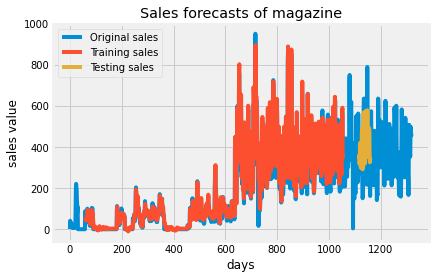

In [ ]:
#plot the predict_sales and training_sales against original sales
plt.plot(MMscaler.inverse_transform(df_sales_scaled), label='Original sales')
plt.plot(train_sales, label='Training sales')
plt.plot(predict_sales, label='Testing sales')
plt.title("Sales forecasts of magazine")
plt.xlabel('days')
plt.ylabel('sales value')
plt.legend()
plt.show()